# Task 01: Introduction to Pytorch

## Introduction

The goal of this task is to get us thinking not just about training models, but about our *training pipelines*.

A neural network is a function, $f$, that accepts in data inputs, $\boldsymbol{X}$, and weights, $\boldsymbol{\Theta}$ that produces labels $\boldsymbol{\hat{y}}$,

$$
\boldsymbol{\hat{y}} = f(\Theta; \boldsymbol{X}).
$$

Meanwhile, a neural network training process, is itself a function, $g$, which accepts as input a dataset $x$, and for supervised algorithms a set of targets $y$, along with a set of parameters $\boldsymbol{\Omega}$ which define how the process is performed, and produces as output the weights of a neural network, $\boldsymbol{\Theta}$,

$$
\Theta = g(\boldsymbol{\Omega}; \boldsymbol{X}, \boldsymbol{y}).
$$

It is helpful to think of the training function, $g$, as a pipeline, composed of several training steps, which can include preprocessing, post processing, etc.

$$
g = g_N \circ\ \cdots\ \circ g_1.
$$

For example, $g_1$ might be a preprocessing step, then $g_2$ might be a training step, and $g_3$ might be a pruning step in a basic pipeline where data $(\boldsymbol{X}, \boldsymbol{y})$ goes in and weights $\boldsymbol{\Theta}$ come out.

We will learn to think of the training process this way by modifying some example code for a basic MNIST classification task. We begin with some imports.

In [87]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 01 - Part 1

Your first task is to:

* Add layer definitions to the following neural network class
* Define the forward pass

You can find starting architectures online. It is important to know there is no known theory to identify a best architecture *before* starting the problem. Trial and error (by iterative training and testing) is the only way to prove or disprove the utility of an architecture.

That said, recall some intuition about the way linear and nonlinear transforms work. We know we need a chain of both to have any hope of solving this problem. We also know that we need some depth, and cannot solve this problem by width alone.


In [83]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def run_training_epoch(
    training_params, model, device, train_loader, optimizer, epoch
):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % training_params.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if training_params.dry_run:
                break


def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

## Helper Code: Training Pipeline

For this assignment, the training pipeline is defined for you. Notice the similarities to the mathematical description of a trainer we saw above.

In [84]:
@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 14
    lr: float = 0.01
    gamma: float = 0.7
    normalizer_mean = 0.1307
    normalizer_std = 0.3081
    no_cuda: bool = True  # Enable or disable CUDA
    no_mps: bool = True  # Enable or disable GPU on MacOS
    dry_run: bool = False
    seed: int = 1
    log_interval: int = 10
    save_model: bool = True


def configure_training_device(training_params):
    use_cuda = not training_params.no_cuda and torch.cuda.is_available()
    use_mps = not training_params.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(training_params.seed)

    if use_cuda:
        device = torch.device("cuda")
        print("a")
    elif use_mps:
        device = torch.device("mps")
        print("b")
    else:
        device = torch.device("cpu")

    train_kwargs = {"batch_size": training_params.batch_size}
    test_kwargs = {"batch_size": training_params.test_batch_size}

    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    return device, train_kwargs, test_kwargs


def build_preprocessing_transform(training_params):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (training_params.normalizer_mean,),
                (training_params.normalizer_std,),
            ),
        ]
    )

    return transform


def build_data_loaders(train_kwargs, test_kwargs, transform):
    dataset1 = datasets.MNIST(
        "../data", train=True, download=True, transform=transform
    )
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    return train_loader, test_loader


def train(training_params, device, train_loader, test_loader):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

        if training_params.save_model:
            torch.save(model.state_dict(), "mnist_cnn.pt")

## Example: Execute a Training Pipeline

With our training steps defined in modular fashion, we can easily define and execute a training pipeline.

In [86]:
def execute_training_pipeline():
    training_params = TrainingParameters(epochs=1, dry_run=False)
    device, train_kwargs, test_kwargs = configure_training_device(
        training_params
    )
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(
        train_kwargs, test_kwargs, transform
    )
    train(training_params, device, train_loader, test_loader)


execute_training_pipeline()

c
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312171
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.267940
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.198024
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.138783
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.058892
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.019918
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.841371
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.720107
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.764942
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.568656
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.352335
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.342799
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.322599
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.237858
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.012112
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.943284
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.178383
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.955121
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.928895
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.892508
Train Epoch: 1 [12800/60000

# Task 01 - Part 2: Explore Width

Using the example above, define a network with a single hidden layer.

Modify the trainer to store the train and test errors in a numpy vector.

Create a for loop over to iterate through a few different amounts of hidden neurons and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

(It should be hard to get good convergence here - this is part of the exercise.)

c
Training with hidden size: 10
Training with hidden size: 20
Training with hidden size: 50
Training with hidden size: 100
Training with hidden size: 200
Training with hidden size: 500


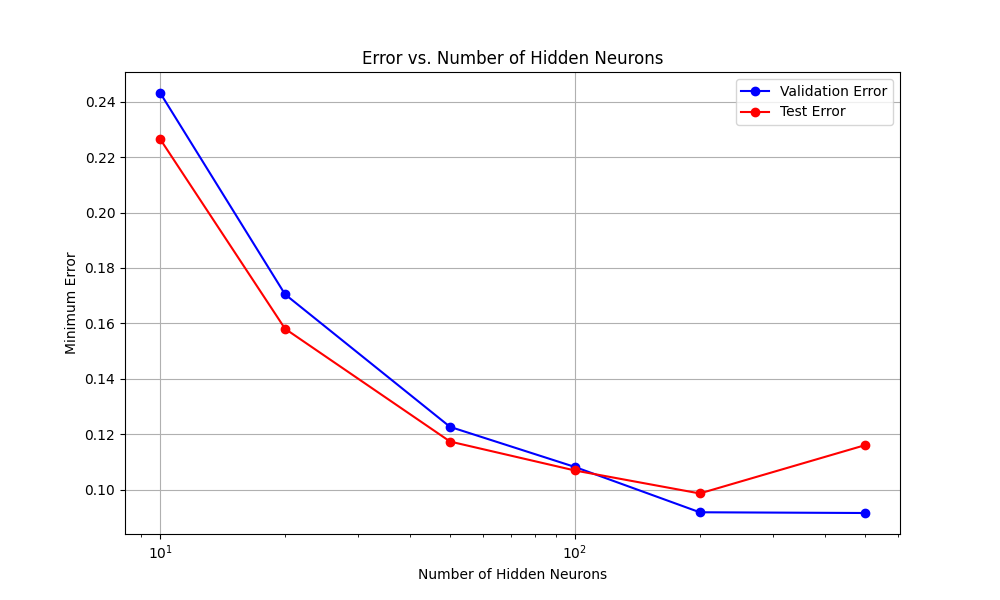

In [88]:
# Your code here
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split

class SimpleNet(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train_and_evaluate(model, device, train_loader, val_loader, test_loader, epochs=10):
    optimizer = optim.Adam(model.parameters())
    train_errors = []
    val_errors = []

    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        train_loss = evaluate(model, device, train_loader)
        train_errors.append(train_loss)

        # Evaluation on validation set
        val_loss = evaluate(model, device, val_loader)
        val_errors.append(val_loss)

        if epoch > 5 and val_errors[-1] > val_errors[-2]:
            break

    test_loss = evaluate(model, device, test_loader)
    return min(val_errors), test_loss

def evaluate(model, device, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += F.nll_loss(output, target, reduction='sum').item()
    return total_loss / len(data_loader.dataset)

def explore_hidden_sizes():
    training_params = TrainingParameters(epochs=50, dry_run=False)
    device, train_kwargs, test_kwargs = configure_training_device(training_params)
    transform = build_preprocessing_transform(training_params)
    
    # Data
    full_train_dataset = datasets.MNIST("../data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("../data", train=False, transform=transform)
    
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    
    train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
    val_loader = torch.utils.data.DataLoader(val_dataset, **test_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

    hidden_sizes = [10, 20, 50, 100, 200, 500]
    min_errors = []
    test_errors = []

    for hidden_size in hidden_sizes:
        print(f"Training with hidden size: {hidden_size}")
        model = SimpleNet(hidden_size).to(device)
        min_error, test_error = train_and_evaluate(model, device, train_loader, val_loader, test_loader)
        min_errors.append(min_error)
        test_errors.append(test_error)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_sizes, min_errors, 'b-o', label='Validation Error')
    plt.plot(hidden_sizes, test_errors, 'r-o', label='Test Error')
    plt.xlabel('Number of Hidden Neurons')
    plt.ylabel('Minimum Error')
    plt.title('Error vs. Number of Hidden Neurons')
    plt.legend()
    plt.xscale('log')
    plt.grid(True)
    plt.show()

explore_hidden_sizes()


Task 01 - Part 3: Explore Depth

Now using the example above, define several networks with increasing numbers of hidden layers (either convolutional or fully connected).

As above, create a for loop over to iterate through a few different depths and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

This example should converge much better.

Depth: 1, Minimum Error: 0.06646229228973388
Depth: 2, Minimum Error: 0.06184009609222412
Depth: 3, Minimum Error: 0.06092314929962158
Depth: 4, Minimum Error: 2.3012507568359375
Depth: 5, Minimum Error: 0.050003164482116697


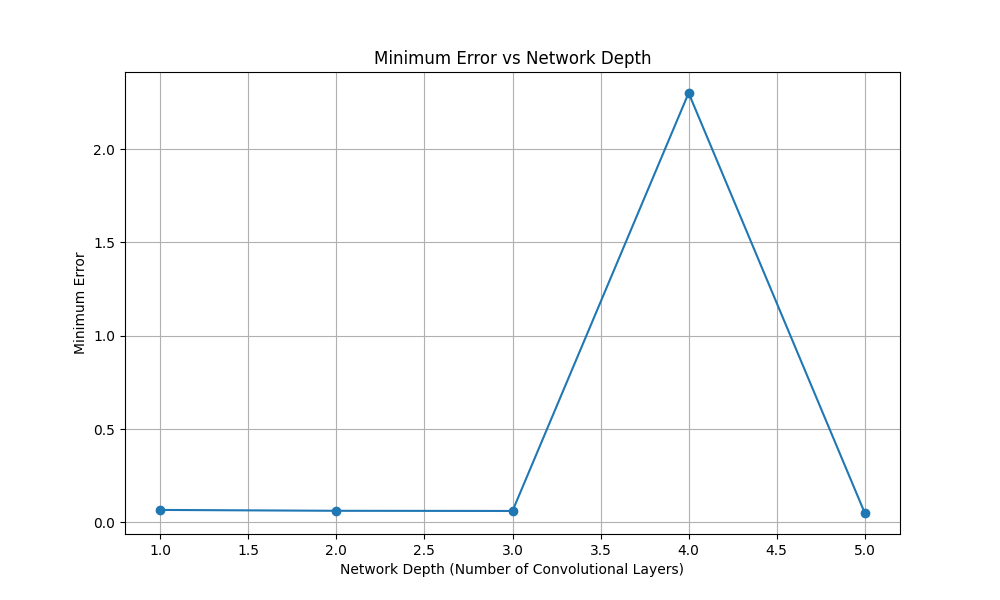

In [92]:
# Your code here
class VariableDepthNet(nn.Module):
    def __init__(self, num_conv_layers, num_fc_layers):
        super(VariableDepthNet, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.fc_layers = nn.ModuleList()
        
        # Convolutional layers
        in_channels = 1
        for _ in range(num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, 32, 3, 1))
            in_channels = 32

        self.flatten_size = 32 * (28 - 2*num_conv_layers) * (28 - 2*num_conv_layers)
        
        fc_size = self.flatten_size
        for _ in range(num_fc_layers - 1):
            self.fc_layers.append(nn.Linear(fc_size, 128))
            fc_size = 128
        self.fc_layers.append(nn.Linear(fc_size, 10))

    def forward(self, x):
        for conv in self.conv_layers:
            x = F.relu(conv(x))
        x = torch.flatten(x, 1)
        for fc in self.fc_layers[:-1]:
            x = F.relu(fc(x))
        x = self.fc_layers[-1](x)
        return F.log_softmax(x, dim=1)

def train_and_evaluate(model, device, train_loader, test_loader, epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    
    min_test_loss = float('inf')
    
    for epoch in range(1, epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        min_test_loss = min(min_test_loss, test_loss)
        
        scheduler.step()
    
    return min_test_loss

def explore_depths():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    train_kwargs = {'batch_size': 256}
    test_kwargs = {'batch_size': 1500}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('../data', train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

    depths = range(1, 6)  # Depth with 1 to 5 layers
    min_errors = []

    for depth in depths:
        model = VariableDepthNet(num_conv_layers=depth, num_fc_layers=2).to(device)
        min_error = train_and_evaluate(model, device, train_loader, test_loader, epochs=5)
        min_errors.append(min_error)
        print(f"Depth: {depth}, Minimum Error: {min_error}")

    plt.figure(figsize=(10, 6))
    plt.plot(depths, min_errors, marker='o')
    plt.title('Minimum Error vs Network Depth')
    plt.xlabel('Network Depth (Number of Convolutional Layers)')
    plt.ylabel('Minimum Error')
    plt.grid(True)
    plt.show()

explore_depths()